<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


## Подготовка

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import optuna
import numpy as np

In [5]:
data = pd.read_csv('taxi.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
data['datetime'] = data['datetime'].astype('datetime64')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
data = data.set_index('datetime')

In [10]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


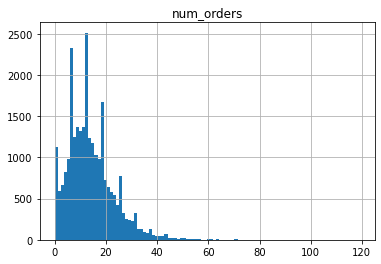

In [11]:
data.hist(bins=100);

In [12]:
data = data.resample('1H').sum()

In [13]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [14]:
data.index.is_monotonic

True

Вывод: Загржуен датасет, изменён тип колонки 'datetime' и назначен на индексы датафрейма, данные расположены по порядку, пропусков и аномальных значений не наблюдается.

## Анализ

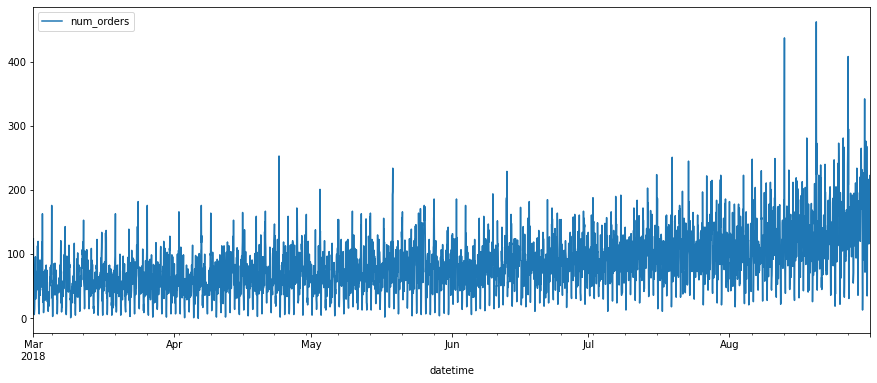

In [15]:
data.plot(figsize=(15,6));

In [16]:
decompose = seasonal_decompose(data)

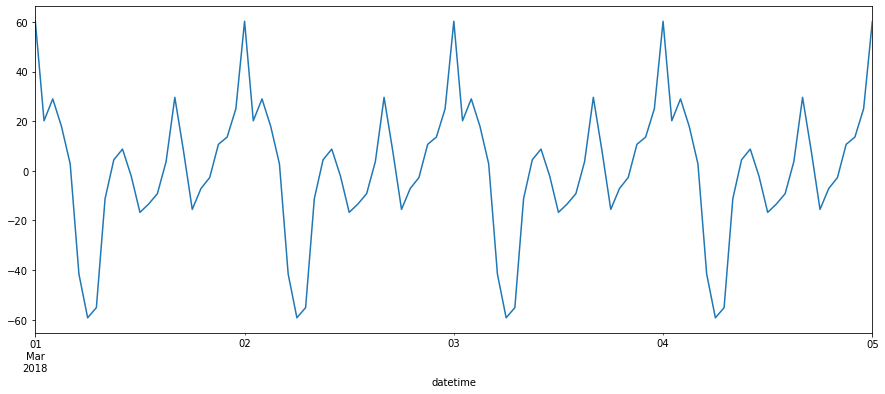

In [17]:
decompose.seasonal.plot(figsize=(15,6),xlim=('2018-03-01','2018-03-05'));

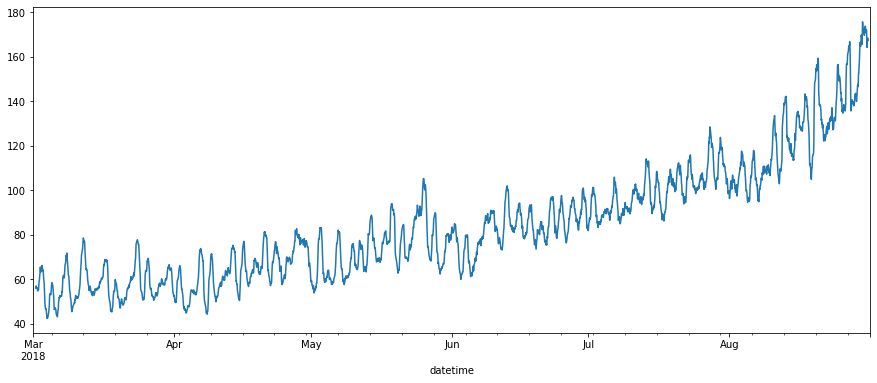

In [18]:
decompose.trend.plot(figsize=(15,6));

Вывод: Из графиков можно заметить, что есть тенденция роста количества заказов с каждым месяцем, а также есть периодичность, которая наблюдается каждые 24 часа, связана с тем, что кол-во заказов увеличивается к ночи.

## Обучение

In [19]:
def new_col(data,max_lag,max_roll):
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day']  = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1,max_lag+1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling'] = df['num_orders'].shift().rolling(max_roll).mean()    
    return df

In [20]:
df = new_col(data,50,5)

In [21]:
df

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,159.0,174.0
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,174.6
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,182.2


In [22]:
train, test = train_test_split(df,shuffle=False,test_size=0.1)

In [23]:
train = train.dropna()

In [24]:
features_train = train.drop(columns='num_orders')
target_train = train['num_orders']
features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

In [25]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)


In [26]:
features_train

array([[ 0.        , -1.43868038, -1.39672176, ...,  0.19165584,
         1.21970007,  1.2191134 ],
       [ 0.        , -1.43868038, -1.39672176, ..., -0.17760748,
         0.19121323,  0.67596987],
       [ 0.        , -1.43868038, -1.39672176, ..., -0.30948724,
        -0.17798718,  0.28290547],
       ...,
       [ 0.        ,  1.74935995, -0.2604882 , ...,  1.64233316,
         1.11421424,  0.69026312],
       [ 0.        ,  1.74935995, -0.2604882 , ...,  0.08615203,
         1.64164339,  1.24769991],
       [ 0.        ,  1.74935995, -0.2604882 , ..., -0.38861509,
         0.0857274 ,  1.62647105]])

In [27]:
lin = LinearRegression()
lin.fit(features_train,target_train)
lin_pred = lin.predict(features_test)

In [28]:
print('LinearRegression RMSE:',mean_squared_error(target_test,lin_pred)**0.5)

LinearRegression RMSE: 43.18342774243338


In [29]:
param = { 'depth' : [6,8,10],
          'learning_rate' : [0.01, 0.05, 0.1],
          'iterations'    : [100,200]
        }

cat = CatBoostRegressor(iterations=100,verbose=False)

tscv = TimeSeriesSplit(n_splits=8)

grid_search = GridSearchCV(estimator = cat, 
                           param_grid = param, 
                           cv = tscv,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(features_train, target_train)

F:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "F:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\Anaconda\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "F:\Anaconda\lib\site-packages\catboost\core.py", line 2355, in _fit
    self._train(
  File "F:\Anaconda\lib\site-packages\

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000143AF218E50>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error')

In [30]:
print('CatBoostRegressor')
print('Best param: ',grid_search.best_params_)
print('Best RMSE: ', (abs(grid_search.best_score_))**0.5)

CatBoostRegressor
Best param:  {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best RMSE:  23.76215544147687


In [31]:
train_data = lgb.Dataset(features_train,label=target_train)
test_data = lgb.Dataset(features_test,label=target_test)

In [32]:
param_grid = {'learning_rate': [0.1, 0.3],
              'max_depth': [5,15],
             }

lgbm = lgb.LGBMRegressor()

tscv = TimeSeriesSplit(n_splits=8)
# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = tscv,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(features_train, target_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [5, 15]},
             scoring='neg_mean_squared_error')

In [33]:
print('LGBMRegressor')
print('Best param: ',grid_search.best_params_)
print('Best RMSE: ', (abs(grid_search.best_score_))**0.5)

LGBMRegressor
Best param:  {'learning_rate': 0.1, 'max_depth': 5}
Best RMSE:  23.892977190240728


In [35]:
param_grid = {'n_estimators': [100,250],
              'max_depth': [5,15],
             }

rf = RandomForestRegressor()

tscv = TimeSeriesSplit(n_splits=8)
# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = tscv,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(features_train, target_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 15], 'n_estimators': [100, 250]},
             scoring='neg_mean_squared_error')

In [36]:
print('RandomForestRegressor')
print('Best param: ',grid_search.best_params_)
print('Best RMSE: ', (abs(grid_search.best_score_))**0.5)

RandomForestRegressor
Best param:  {'max_depth': 15, 'n_estimators': 250}
Best RMSE:  24.237944155629567


Вывод: Были обучены 4 модели, у всех моделей адекватные метрики, самая лучшая у CatBoostRegressor.

In [37]:
X_train = features_train.copy()
y_train = target_train.copy()

In [38]:
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [39]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    window_size = trial.suggest_int('window_size', 5, 20)

    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]['num_orders'].values
    test_data = data.iloc[train_size:]['num_orders'].values

    X_train, y_train = create_sliding_window(train_data, window_size)
    X_test, y_test = create_sliding_window(test_data, window_size)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    return mse


In [40]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2023-07-05 14:09:22,242] A new study created in memory with name: no-name-3cce2a7b-d911-4d7a-b79b-3940b73184b1
[I 2023-07-05 14:09:22,446] Trial 0 finished with value: 3533.6815201201184 and parameters: {'n_estimators': 43, 'max_depth': 3, 'window_size': 12}. Best is trial 0 with value: 3533.6815201201184.
[I 2023-07-05 14:09:23,053] Trial 1 finished with value: 2874.6804225299534 and parameters: {'n_estimators': 88, 'max_depth': 6, 'window_size': 10}. Best is trial 1 with value: 2874.6804225299534.
[I 2023-07-05 14:09:24,088] Trial 2 finished with value: 2823.8429151678592 and parameters: {'n_estimators': 98, 'max_depth': 7, 'window_size': 14}. Best is trial 2 with value: 2823.8429151678592.
[I 2023-07-05 14:09:28,523] Trial 3 finished with value: 2704.0951367561183 and parameters: {'n_estimators': 473, 'max_depth': 9, 'window_size': 10}. Best is trial 3 with value: 2704.0951367561183.
[I 2023-07-05 14:09:37,434] Trial 4 finished with value: 2782.9394992025195 and parameters: {'n_e

[I 2023-07-05 14:10:47,969] Trial 41 finished with value: 2511.9930983727118 and parameters: {'n_estimators': 83, 'max_depth': 10, 'window_size': 19}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:10:49,752] Trial 42 finished with value: 2498.6962752993645 and parameters: {'n_estimators': 94, 'max_depth': 10, 'window_size': 19}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:10:50,698] Trial 43 finished with value: 2554.227634565795 and parameters: {'n_estimators': 52, 'max_depth': 10, 'window_size': 18}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:10:54,489] Trial 44 finished with value: 2511.354634925073 and parameters: {'n_estimators': 202, 'max_depth': 10, 'window_size': 19}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:10:55,747] Trial 45 finished with value: 2654.255681773911 and parameters: {'n_estimators': 85, 'max_depth': 9, 'window_size': 16}. Best is trial 28 with value: 2470.0427284585635.
[I 

[I 2023-07-05 14:12:07,861] Trial 83 finished with value: 2481.1741866141483 and parameters: {'n_estimators': 130, 'max_depth': 10, 'window_size': 19}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:12:10,464] Trial 84 finished with value: 2540.4958755527764 and parameters: {'n_estimators': 128, 'max_depth': 10, 'window_size': 20}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:12:11,455] Trial 85 finished with value: 3155.0210363929955 and parameters: {'n_estimators': 156, 'max_depth': 9, 'window_size': 6}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:12:15,106] Trial 86 finished with value: 2494.8545644834626 and parameters: {'n_estimators': 200, 'max_depth': 10, 'window_size': 18}. Best is trial 28 with value: 2470.0427284585635.
[I 2023-07-05 14:12:17,089] Trial 87 finished with value: 2491.949075760686 and parameters: {'n_estimators': 112, 'max_depth': 10, 'window_size': 17}. Best is trial 28 with value: 2470.0427284585635

In [41]:
print('Best hyperparameters: ', study.best_params)


Best hyperparameters:  {'n_estimators': 104, 'max_depth': 10, 'window_size': 19}


In [42]:
best_params = study.best_params
train_size = int(len(data) * 0.8)
train_data = df.iloc[:train_size]['num_orders'].values
test_data = df.iloc[train_size:]['num_orders'].values

X_train, y_train = create_sliding_window(train_data, best_params['window_size'])
X_test, y_test = create_sliding_window(test_data, best_params['window_size'])

model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error on test set: ', mse**.5)


Mean Squared Error on test set:  49.69952442889734


## Тестирование

In [43]:
cat = CatBoostRegressor(iterations=200,verbose=False,learning_rate=0.1,depth=6)
cat.fit(features_train,target_train)
cat_pred = cat.predict(features_test)

In [44]:
print('RMSE:',mean_squared_error(target_test,cat_pred)**0.5)

RMSE: 40.02096865221426


In [45]:
pred = pd.Series(cat_pred,index = target_test.index)

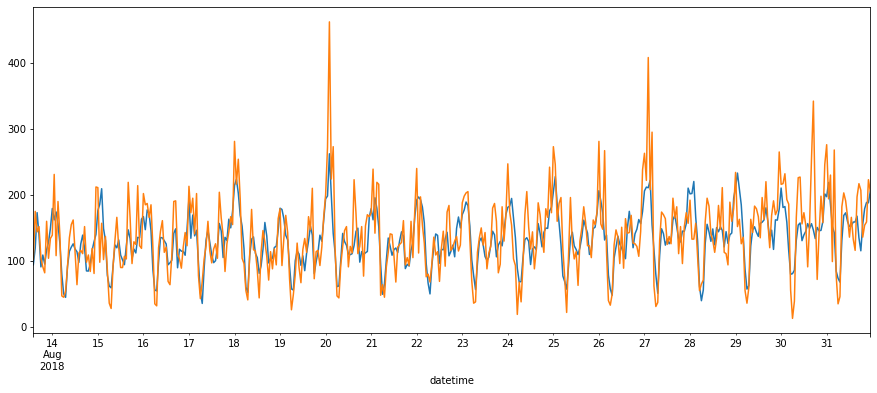

In [46]:
pred.plot(figsize=(15,6));
target_test.plot();

Вывод: Модель была проверена на тестовой выборке и показала хороший результат

Общий вывод: 
1. Был загружен и подготовлен датасет
2. Был проанализорованы тренд и сезоность заказов
3. Обучено 4 модели и выбрана лучшая
4. Модели показали удовлетворительные метрики
5. Лучшая модель протестирована на тестовой выборке и показала хорошее качество

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48